In [1]:
import pandas as pd
import numpy as np

In [3]:

df_sales= pd.read_csv(r"C:\Users\kazak\OneDrive\Рабочий стол\project2\sales.csv")

In [15]:
df_sales['TIME_ID'] = pd.to_datetime(df_sales['TIME_ID'])

# Pre-period (до 2023-01-01)
pre_period = df_sales[df_sales['TIME_ID'] < '2023-01-01']

#### Активные пользователи + их pre-revenue (ARPU на уровне пользователя)

In [5]:
pre_user_revenue = (
    pre_period
    .groupby('CUST_ID')['AMOUNT_SOLD']
    .sum()
    .reset_index()
    .rename(columns={'AMOUNT_SOLD':'pre_revenue'})
)


In [6]:
pre_user_revenue

,CUST_ID,pre_revenue
0,2,65520.17
1,3,14041.43
2,4,2640.82
3,6,28362.31
4,7,9468.09
...,...,...
7054,100996,9.99
7055,100997,909.98
7056,100998,44.99
7057,100999,211.97


#### Рандомное деление на группы

In [7]:
np.random.seed(42)

eligible_users = pre_user_revenue['CUST_ID']

sample_users = np.random.choice(
    eligible_users,
    size=6000,
    replace=False
)

test_users = sample_users[:3000]
control_users = sample_users[3000:]


#### Таблица для проверки однородности

In [8]:
ab_pre = pre_user_revenue[
    pre_user_revenue['CUST_ID'].isin(sample_users)
].copy()

ab_pre['group'] = np.where(
    ab_pre['CUST_ID'].isin(test_users),
    'Test',
    'Control'
)


In [41]:
ab_pre.head(30)

,CUST_ID,pre_revenue,group
0,2,65520.17,Control
1,3,14041.43,Control
2,4,2640.82,Control
3,6,28362.31,Control
5,8,7393.75,Control
6,9,30207.19,Control
7,10,6886.84,Control
8,11,9003.25,Test
10,13,11265.99,Control
11,14,23696.17,Control


#### Сравнение средних и медиан

In [10]:
ab_pre.groupby('group')['pre_revenue'].agg(['mean','median','std','count'])


,mean,median,std,count
group,,,,
Control,13950.754390,9679.935,13358.341183,3000
Test,13885.237553,9395.940,13578.539306,3000


#### t-test (A/A тест логики)

In [13]:
from scipy.stats import ttest_ind

test_pre = ab_pre[ab_pre['group']=='Test']['pre_revenue']
control_pre = ab_pre[ab_pre['group']=='Control']['pre_revenue']

t_stat, p_value = ttest_ind(test_pre, control_pre, equal_var=False)

t_stat, p_value


(np.float64(-0.1883938562804717), np.float64(0.8505742905480356))

#### p_value = 0.85

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 271.89it/s]


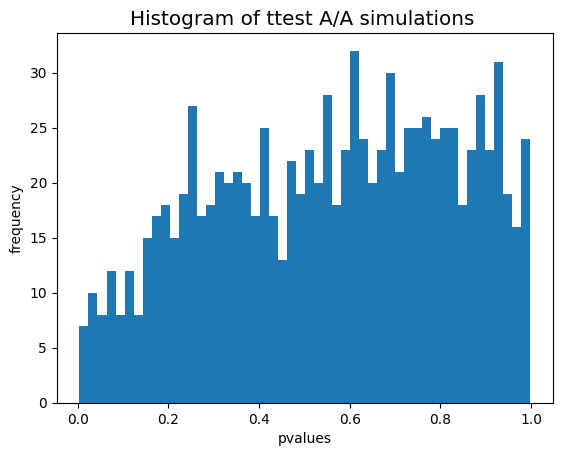

Процент ложноположительных результатов: 0.020. В 2.0% случаев мы ошибочно обнаруживали значимую разницу между одинаковыми группами.


In [33]:
from tqdm import tqdm
from scipy import stats
from matplotlib import pyplot as plt
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = ab_pre[ab_pre.group == 'Control']['pre_revenue'].sample(n_s, replace = False).values
    s2 = ab_pre[ab_pre.group == 'Test']['pre_revenue'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
false_positives_rate = sum(np.array(res) < 0.05) / simulations
print(f"Процент ложноположительных результатов: {false_positives_rate:.3f}. "
      f"В {false_positives_rate * 100:.1f}% случаев мы ошибочно обнаруживали значимую разницу между одинаковыми группами.")

### Вывод

- В pre-period были отобраны активные пользователи и рассчитана выручка на пользователя (pre-revenue).
- Пользователи были случайным образом разделены на Test и Control группы по 3000 человек.
- Проверка однородности по ARPU показала отсутствие статистически значимых различий между группами (p-value > 0.05), что подтверждает корректность рандомизации и валидность дальнейшего эксперимента.

### A/B test

In [35]:
df_ab= pd.read_excel(r"C:\Users\kazak\Downloads\ab_test_data.xlsx")

In [42]:
df_ab.head()

,user_id,group,period,gmv,conversion,push_sent,push_delivered,push_purchase
0,1,test,before,2320.907714,NaN,NaN,NaN,NaN
1,1,test,after,1732.908690,0.0,0.0,0.0,0.0
2,2,control,before,2756.026435,NaN,NaN,NaN,NaN
3,2,control,after,2289.183980,0.0,NaN,NaN,NaN
4,3,control,before,2661.288971,NaN,NaN,NaN,NaN


- Взял after как test-period и посчитал по группам:

In [43]:
after = df_ab[df_ab['period'] == 'after'].copy()

In [44]:
arpu_table = (
    after.groupby('group')
    .agg(
        users=('user_id','nunique'),
        revenue=('gmv','sum'),
        ARPU=('gmv','mean')
    )
)

arpu_table

,users,revenue,ARPU
group,,,
control,2500,5.994328e+06,2397.731011
test,2500,6.121216e+06,2448.486236


- Посчитали uplift, чтобы узнать насколько тестовый ARPU от контрольный ARPU больше

In [45]:
arpu_test = arpu_table.loc['test','ARPU']
arpu_ctrl = arpu_table.loc['control','ARPU']

uplift_abs = arpu_test - arpu_ctrl
uplift_pct = uplift_abs / arpu_ctrl * 100

uplift_abs, uplift_pct

(np.float64(50.755225230031556), np.float64(2.1168023019501243))

#### Проверил значимость:
- ARPU: t-test по распределению gmv (revenue_per_user).
- Conversion: z-test пропорций.

In [46]:
from scipy.stats import ttest_ind

t = after[after['group']=='test']['gmv']
c = after[after['group']=='control']['gmv']

t_stat, p_arpu = ttest_ind(t, c, equal_var=False)
p_arpu

np.float64(2.5447274984150766e-09)

p_arpu < 0.05 - эффект по ARPU значим

In [50]:
conv_table = (
    after.groupby('group')['conversion']
    .mean()
)

conv_table

group
control    0.0272
test       0.0372
Name: conversion, dtype: float64

In [ ]:
2448/

In [52]:
from statsmodels.stats.proportion import proportions_ztest

success = [
    after[after['group']=='test']['conversion'].sum(),
    after[after['group']=='control']['conversion'].sum()
]

nobs = [
    len(after[after['group']=='test']),
    len(after[after['group']=='control'])
]

z_stat, p_conv = proportions_ztest(success, nobs)
p_conv

np.float64(0.04520040439651734)

p_conv < 0.05 - конверсия выросла значимо

#### Финальные результаты

In [57]:
before = df_ab[df_ab['period'] == 'before'].copy()

In [58]:
arpu_before = (
    before.groupby('group')['gmv']
    .mean()
    .rename('ARPU_before')
)

In [65]:
arpu_after = (
    after.groupby('group')['gmv']
    .mean()
    .rename('ARPU_after')
)

In [63]:
users = (
    after.groupby('group')['user_id']
    .nunique()
    .rename('users')
)

In [66]:
conversion = (
    after.groupby('group')['conversion']
    .mean()
    .rename('conversion')
)

In [60]:
push = (
    after.groupby('group')
    .agg(
        push_sent=('push_sent','sum'),
        push_delivered=('push_delivered','sum'),
        push_purchase=('push_purchase','sum')
    )
)

In [64]:
push['push_sent_rate'] = push['push_sent'] / users
push['push_delivered_rate'] = push['push_delivered'] / push['push_sent']
push['push_purchase_rate'] = push['push_purchase'] / push['push_delivered']

In [67]:
final = pd.concat(
    [users, arpu_before, arpu_after, conversion, push],
    axis=1
)

In [69]:
final['ARPU_uplift_abs'] = (
    final['ARPU_after'] - final.loc['control', 'ARPU_after']
)

final['ARPU_uplift_pct'] = (
    final['ARPU_uplift_abs'] / final.loc['control', 'ARPU_after'] * 100
)

In [70]:
final['conversion_uplift_abs'] = (
    final['conversion'] - final.loc['control', 'conversion']
)

final['conversion_uplift_pct'] = (
    final['conversion_uplift_abs'] / final.loc['control', 'conversion'] * 100
)

In [71]:
final.loc['control', [
    'ARPU_uplift_abs', 'ARPU_uplift_pct',
    'conversion_uplift_abs', 'conversion_uplift_pct'
]] = 0

In [72]:
final

,users,ARPU_before,ARPU_after,conversion,push_sent,push_delivered,push_purchase,push_sent_rate,push_delivered_rate,push_purchase_rate,ARPU_uplift_abs,ARPU_uplift_pct,conversion_uplift_abs,conversion_uplift_pct
group,,,,,,,,,,,,,,
control,2500,2502.610986,2397.731011,0.0272,0.0,0.0,0.0,0.0000,NaN,NaN,0.000000,0.000000,0.00,0.000000
test,2500,2497.721785,2448.486236,0.0372,2242.0,1815.0,75.0,0.8968,0.809545,0.041322,50.755225,2.116802,0.01,36.764706


### Вывод
Эксперимент показал, что отправка пуш-уведомления со скидкой 10% приводит к статистически значимому росту как вероятности покупки, так и выручки на пользователя. Конверсия увеличилась с 2.72% до 3.72%, что составляет +1 п.п. в абсолютном выражении и +36.8% uplift относительно контрольной группы, а ARPU вырос на 2.1%. Полученные результаты свидетельствуют о высокой эффективности промо-коммуникации и целесообразности масштабирования данного механизма.